# Accessing the project directory on my Google Drive  

In [1]:
import os
from google.colab import drive

drive.mount('/drive', force_remount=False)
project_dir = "/drive/My Drive/RNNSeq2Seq/"

# change working directory to project_dir
os.chdir(project_dir)

Mounted at /drive


# Dependencies

In [2]:
from scripts.model import *
from scripts.dataloader import create_dataloader
from scripts.utils import *
from scripts.pytorch_utils import *
import matplotlib.pyplot as plt

# Helper function to help visualize 

In [3]:
def plot_log(log):
    len_range = len(log) -1 if "Best eval accu" in log else len(log)
    epoch_nums, train_loss, dev_loss = [], [], []
    train_acc, dev_acc = [], []

    for epoch in range(1, len_range+1):
        epoch_nums.append(epoch)
        train = log[f"Epoch#{epoch}"]["Train"]
        dev = log[f"Epoch#{epoch}"]["Eval"]
        train_loss.append(train['loss'])
        train_acc.append(train['abosulate accuracy'])

        dev_loss.append(dev['loss'])
        dev_acc.append(dev['abosulate accuracy'])

    ax1 = plt.subplot(211)
    ax1.plot(epoch_nums, train_loss, label="train loss")
    ax1.plot(epoch_nums, dev_loss, label="dev loss")
    ax1.legend()

    ax2 = plt.subplot(212)
    ax2.plot(epoch_nums, train_acc, label="train acc")
    ax2.plot(epoch_nums, dev_acc, label="dev acc")
    ax2.legend()
    plt.show()

In [4]:
folder = "tuning_data/"
experiment_num = 7
shuffle_batch = False

# must be the num of seq per seq length if shuffle_batch is False
# this "tr_batch_size" will be used for dev, and shuffled test sets
tr_batch_size = 250 
dev_batch_size = 500 if not shuffle_batch else tr_batch_size

In [5]:
# setups for training and evaluting

print_freq = 5
acc_threshold = 0.5 # for saving the best trained models 
max_epoch_num = 150 # max num of epoches 
train_acc_exit=0.92 # train acc exit threshold (eval_acc_exit must also be met)
eval_acc_exit=0.92 # dev acc exit threshold (train_acc_exit must also be met)
teacher_forcing_ratio = 1.0 # probability of using real symbol from target sequence for training

# RevStr

In [6]:
train = read_data(join(folder, "RevStr/train.txt"))
dev = read_data(join(folder, "RevStr/dev.txt"))
saved_model_fp = join(project_dir, "notebooks/Hyperparatemers Tuning/RevStr_rnn_model.pt")

train_dl = create_dataloader(train, batch_size=tr_batch_size, shuffle=shuffle_batch)
dev_dl = create_dataloader(dev, batch_size=dev_batch_size, shuffle=shuffle_batch)

## Hyperparameter set 1


In [7]:
in_vocab = ascii_lowercase
out_vocab = ascii_lowercase
in_vocab_size = len(in_vocab) + 2
out_vocab_size = len(out_vocab) + 2

hidden_size = 512
embd_dim = 512
num_layers = 1
rnn_type = "RNN"
dropout_rate = 0.0
bidirectional = False
use_attention = False
reduction_method = torch.sum

learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [8]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 2.7977419078350065, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.012187706772238016, 'overlap rate': 0.21831603944301606}
evaluation performance: {'loss': 3.0326196551322937, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.014060374279506505, 'overlap rate': 0.1532103018835187}

Current epoch: 10, 
training performance: {'loss': 2.1912750482559202, 'abosulate accuracy': 0.00020000000949949026, 'consecutive overlap rate': 0.055384640907868744, 'overlap rate': 0.4095225058495998}
evaluation performance: {'loss': 3.0871468782424927, 'abosulate accuracy': 0.000450000015553087, 'consecutive overlap rate': 0.05124492757022381, 'overlap rate': 0.19310278985649348}

Current epoch: 15, 
training performance: {'loss': 1.8605259954929352, 'abosulate accuracy': 0.0042000001994892955, 'consecutive overlap rate': 0.10140251228585839, 'overlap rate': 0.5086715437471867}
evaluation performance: {'loss': 3.1108101308345795, 'abosula

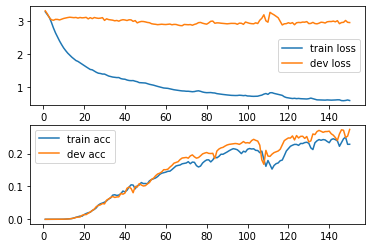

In [9]:
plot_log(log)

## Hyperparameter set 2

In [10]:
hidden_size = 512
embd_dim = 512
num_layers = 1
rnn_type = "RNN"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [11]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 2.9834620356559753, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0077717521344311535, 'overlap rate': 0.16022162679582835}
evaluation performance: {'loss': 3.0592810809612274, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.00822846220107749, 'overlap rate': 0.14087696373462677}

Current epoch: 10, 
training performance: {'loss': 2.4968921065330507, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.024460723088122905, 'overlap rate': 0.3094802636653185}
evaluation performance: {'loss': 3.0459951162338257, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.024909821059554815, 'overlap rate': 0.1698085691779852}

Current epoch: 15, 
training performance: {'loss': 2.1601588398218157, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.05155854453332722, 'overlap rate': 0.4206817716360092}
evaluation performance: {'loss': 3.0843776166439056, 'abosulate accuracy': 0.0003000000026077032, 'consecutive ove

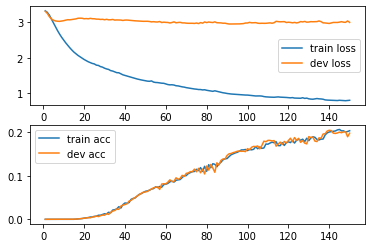

In [12]:
plot_log(log)

## Hyperparameter set 3

In [13]:
hidden_size = 1024
embd_dim = 512
num_layers = 1
rnn_type = "RNN"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [15]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 3.296240818500519, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.004853795409144368, 'overlap rate': 0.036575421178713444}
evaluation performance: {'loss': 3.302756267786026, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0014862381933198777, 'overlap rate': 0.03862762525677681}

Current epoch: 10, 
training performance: {'loss': 3.299524813890457, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0020506628941802775, 'overlap rate': 0.032904776377836245}
evaluation performance: {'loss': 3.302679604291916, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.004214918235084042, 'overlap rate': 0.04071144973859191}

Current epoch: 15, 
training performance: {'loss': 3.2955494225025177, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0034792917445884085, 'overlap rate': 0.03369225364876911}
evaluation performance: {'loss': 3.300575876235962, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.

KeyboardInterrupt: ignored

## Hyperparameter set 4

In [16]:
hidden_size = 1024
embd_dim = 512
num_layers = 1
rnn_type = "RNN"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [17]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 3.350159007310867, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.001439703773939982, 'overlap rate': 0.03039321703836322}
evaluation performance: {'loss': 3.3206027030944822, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0014841345488093793, 'overlap rate': 0.03873806297779083}

Current epoch: 10, 
training performance: {'loss': 3.3301709055900575, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.00712540855165571, 'overlap rate': 0.03649542229250073}
evaluation performance: {'loss': 3.27487536072731, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.012360142485704273, 'overlap rate': 0.04957231292501092}

Current epoch: 15, 
training performance: {'loss': 3.2135837733745576, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.046771701984107496, 'overlap rate': 0.0745283542200923}
evaluation performance: {'loss': 3.151847207546234, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.06022

KeyboardInterrupt: ignored

# RedStr



In [18]:
train = read_data(join(folder, "RedStr/train.txt"))
dev = read_data(join(folder, "RedStr/dev.txt"))
saved_model_fp = join(project_dir, "notebooks/Hyperparatemers Tuning/RevStr_model.pt")

train_dl = create_dataloader(train, batch_size=tr_batch_size, shuffle=shuffle_batch)
dev_dl = create_dataloader(dev, batch_size=dev_batch_size, shuffle=shuffle_batch)

## Hyperparameter set 1


In [19]:
hidden_size = 512
embd_dim = 512
num_layers = 1
rnn_type = "RNN"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [20]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 3.275782918930054, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0026890551758697256, 'overlap rate': 0.040093489456921816}
evaluation performance: {'loss': 3.2981283962726593, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.00256127918837592, 'overlap rate': 0.043844508845359086}

Current epoch: 10, 
training performance: {'loss': 3.240364211797714, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.003439997971872799, 'overlap rate': 0.041089489730075}
evaluation performance: {'loss': 3.273704159259796, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0026146512827835977, 'overlap rate': 0.03740958999842405}

Current epoch: 15, 
training performance: {'loss': 3.24851308465004, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0032576502446318044, 'overlap rate': 0.04414160829037428}
evaluation performance: {'loss': 3.218305307626724, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0031

KeyboardInterrupt: ignored

## Hyperparameter set 2

In [21]:
hidden_size = 512
embd_dim = 256
num_layers = 1
rnn_type = "RNN"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 3.28694788813591, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0029673397162696346, 'overlap rate': 0.0396587579511106}
evaluation performance: {'loss': 3.2955876290798187, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.003454376439913176, 'overlap rate': 0.04858415871858597}

Current epoch: 10, 
training performance: {'loss': 3.204529792070389, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.004320368453045375, 'overlap rate': 0.04981647534295917}
evaluation performance: {'loss': 3.231331157684326, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.004497422612621449, 'overlap rate': 0.04494937276467681}

Current epoch: 15, 
training performance: {'loss': 3.194491070508957, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.005275997894932516, 'overlap rate': 0.051932140719145536}
evaluation performance: {'loss': 3.239012235403061, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.00480

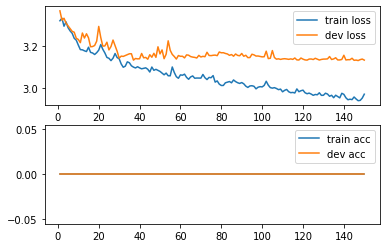

In [23]:
plot_log(log)

## Hyperparameter set 3

In [24]:
hidden_size = 1024
embd_dim = 512
num_layers = 1
rnn_type = "RNN"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 3.2989938080310823, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0016079644672572612, 'overlap rate': 0.03100181029876694}
evaluation performance: {'loss': 3.305458092689514, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.001360159552859841, 'overlap rate': 0.0380749954842031}

Current epoch: 10, 
training performance: {'loss': 3.2961453795433044, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.001594344768091105, 'overlap rate': 0.03168233500327915}
evaluation performance: {'loss': 3.303351658582687, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0013730290156672709, 'overlap rate': 0.03835339546203613}

Current epoch: 15, 
training performance: {'loss': 3.2975727736949922, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0015556372920400463, 'overlap rate': 0.03281423377338797}
evaluation performance: {'loss': 3.2971613585948942, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.

KeyboardInterrupt: ignored

## Hyperparameter set 4

In [28]:
hidden_size = 1024
embd_dim = 512
num_layers = 1
rnn_type = "RNN"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [29]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 7.4249435544013975, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.001740171646088129, 'overlap rate': 0.038335207011550666}
evaluation performance: {'loss': 6.654889452457428, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0014785264713282232, 'overlap rate': 0.03810577690601349}

Current epoch: 10, 
training performance: {'loss': 3.3072599291801454, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0015919681041850708, 'overlap rate': 0.027567013568477704}
evaluation performance: {'loss': 3.3011941492557524, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.001411249472585041, 'overlap rate': 0.03885418474674225}

Current epoch: 15, 
training performance: {'loss': 3.315783643722534, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0016431309071776924, 'overlap rate': 0.028216073580551893}
evaluation performance: {'loss': 3.3297418773174288, 'abosulate accuracy': 0.0, 'consecutive overlap rate'

KeyboardInterrupt: ignored

## Hyperparameter set 5

In [30]:
hidden_size = 512
embd_dim = 512
num_layers = 1
rnn_type = "RNN"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [31]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 3.3147259056568146, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0016167720634257421, 'overlap rate': 0.03255868058186025}
evaluation performance: {'loss': 3.3113495469093324, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0014915682026185096, 'overlap rate': 0.03853747434914112}

Current epoch: 10, 
training performance: {'loss': 3.312589830160141, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0015848954491957557, 'overlap rate': 0.032124896976165475}
evaluation performance: {'loss': 3.3066455125808716, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0014871883337036706, 'overlap rate': 0.0380674852989614}

Current epoch: 15, 
training performance: {'loss': 3.3124352276325224, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.001617826314031845, 'overlap rate': 0.03379454626701772}
evaluation performance: {'loss': 3.308919847011566, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 

KeyboardInterrupt: ignored

## Hyperparameter set 6

In [32]:
hidden_size = 1024
embd_dim = 1024
num_layers = 1
rnn_type = "RNN"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [33]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 3.9435517728328704, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0015242069639498368, 'overlap rate': 0.03840077798813581}
evaluation performance: {'loss': 3.9071877539157867, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0013922866186476313, 'overlap rate': 0.038353250734508036}

Current epoch: 10, 
training performance: {'loss': 3.261242151260376, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0013591371083748528, 'overlap rate': 0.030695266835391522}
evaluation performance: {'loss': 3.278710663318634, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0014907539443811402, 'overlap rate': 0.030178764648735524}

Current epoch: 15, 
training performance: {'loss': 3.2585681915283202, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0016355002444470301, 'overlap rate': 0.032352844765409824}
evaluation performance: {'loss': 3.2700678050518035, 'abosulate accuracy': 0.0, 'consecutive overlap ra

KeyboardInterrupt: ignored

## Hyperparameter set 7

In [34]:
hidden_size = 1024
embd_dim = 1024
num_layers = 1
rnn_type = "RNN"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 5e-5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [35]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 3.2682660102844237, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0018585103884106503, 'overlap rate': 0.038808399438858034}
evaluation performance: {'loss': 3.296911299228668, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.001593282826070208, 'overlap rate': 0.035184357734397056}

Current epoch: 10, 
training performance: {'loss': 3.2035872399806977, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.00424132698244648, 'overlap rate': 0.049003053735941646}
evaluation performance: {'loss': 3.2626172840595244, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.004219383274903521, 'overlap rate': 0.04454238060861826}

Current epoch: 15, 
training performance: {'loss': 3.259922671318054, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.005785875051515177, 'overlap rate': 0.053811265900731084}
evaluation performance: {'loss': 3.2668877720832823, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 

KeyboardInterrupt: ignored

## Hyperparameter set 8

In [38]:
hidden_size = 1024
embd_dim = 1024
num_layers = 1
rnn_type = "RNN"
encoder = Encoder(in_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type, 
                  dropout_rate, bidirectional, 
                  reduction_method)
attention = Attention(hidden_size)
decoder = Decoder(out_vocab_size, hidden_size, 
                  embd_dim, num_layers, rnn_type,
                  attention, use_attention, 
                  dropout_rate)

model = Seq2Seq(encoder, decoder, device).to(device)
model.apply(init_weights)

learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [39]:
log = train_and_evaluate(model, train_dl, dev_dl, criterion, optimizer, 
                         saved_model_fp, acc_threshold, print_freq, max_epoch_num, 
                         train_acc_exit, eval_acc_exit, teacher_forcing_ratio)

Current epoch: 5, 
training performance: {'loss': 3.2864879190921785, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0015767613702337257, 'overlap rate': 0.034649648563936354}
evaluation performance: {'loss': 3.2955746710300446, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0015693004104832653, 'overlap rate': 0.038782233651727435}

Current epoch: 10, 
training performance: {'loss': 3.2886625289916993, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0015886915920418688, 'overlap rate': 0.03409408424049616}
evaluation performance: {'loss': 3.2954188764095305, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0015294514669221826, 'overlap rate': 0.03855784628540278}

Current epoch: 15, 
training performance: {'loss': 3.2886116206645966, 'abosulate accuracy': 0.0, 'consecutive overlap rate': 0.0016061390990216751, 'overlap rate': 0.033909776830114424}
evaluation performance: {'loss': 3.3183106601238253, 'abosulate accuracy': 0.0, 'consecutive overlap r

KeyboardInterrupt: ignored